In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pybamm
from time import time
from datetime import datetime, timedelta
from tqdm import tqdm

from scipy import interpolate
import multiprocessing as mp


print(pybamm.__version__)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15

24.9.0


In [2]:
I1,I2,I3,V1,V2 = [0.20,0.40,0.30,3.70,4.05]
temperature_C = 25

n_days = 100
dch_per_one_day = 10
one_day_time = 24
R_const = 8.314

In [3]:
param = pybamm.ParameterValues("Jeong2024")
options = {"thermal":"lumped","SEI": "ec reaction limited","SEI porosity change":"true","loss of active material":"current and stress-driven","particle mechanics":"swelling only","lithium plating": "irreversible", "lithium plating porosity change": "true"}
param.update(
    {"Initial temperature [K]": 273.15 + temperature_C,
     "Ambient temperature [K]": 273.15 + temperature_C,
     })
model = pybamm.lithium_ion.SPM(options=options)

s = pybamm.step.string

In [4]:
# Initial capacity
capa_0 = 4.910019471679001

solver = pybamm.CasadiSolver(mode='safe', return_solution_if_failed_early=True)
st_time = time()
n_exp_per_day_arr = []
for c in tqdm(range(n_days)):
    st_time_1 = datetime(2024, 1, 1, 0, 0) + timedelta(hours=c*one_day_time)

    experiment1  = pybamm.Experiment([
        (   s(f"Charge at {I1}C until {V1}V",start_time = st_time_1),
            s(f"Charge at {I2}C until {V2}V"),
            s(f"Charge at {I3}C until {4.2}V"),
            "Discharge at 0.1C until 3.0V",)])
    sim = pybamm.Simulation(model, parameter_values=param, experiment=experiment1,solver=solver)
    if c==0:
        solution = sim.solve(initial_soc=0)
    else:
        solution = sim.solve(starting_solution=solution)


    dch_time_exp1 = solution.cycles[-1].steps[-1]['Time [h]'].entries[-1]-solution.cycles[-1].steps[-1]['Time [h]'].entries[0]

    if dch_time_exp1>=dch_per_one_day:
        experiment2  = pybamm.Experiment([
            (   s("Rest for 8 hours",start_time = st_time_2))])
        sim = pybamm.Simulation(model, parameter_values=param, experiment=experiment2,solver=solver)
        solution = sim.solve(starting_solution=solution) 
        n_exp_day = 2
        n_exp_per_day_arr.append(n_exp_day)
        

    else:
        dch_time_left = dch_per_one_day-dch_time_exp1
        experiment2  = pybamm.Experiment([
            (   f"Charge at {I1}C until {V1}V",
                f"Charge at {I2}C until {V2}V",
                f"Charge at {I3}C until {4.2}V",  
                f"Discharge at 0.1C for {dch_time_left} hours or until 3.0V", )]) 
        sim = pybamm.Simulation(model, parameter_values=param, experiment=experiment2,solver=solver)
        solution = sim.solve(starting_solution=solution)    
        dch_time_exp2 = solution.cycles[-1].steps[-1]['Time [h]'].entries[-1]-solution.cycles[-1].steps[-1]['Time [h]'].entries[0]
    
        st_time_2_hr = solution.cycles[-1].steps[-1]['Time [h]'].entries[-1]-solution.cycles[-2]['Time [h]'].entries[0]
        st_time_2_h = int(np.floor(st_time_2_hr))
        st_time_2_m = int(np.floor((st_time_2_hr-st_time_2_h)*60))
        st_time_2_s = int(np.ceil(((st_time_2_hr-st_time_2_h)*60-st_time_2_m)*60))
        if st_time_2_s==60:
            st_time_2_m=st_time_2_m+1
            st_time_2_s=0
        st_time_2 = datetime(2024, 1, 1, st_time_2_h, st_time_2_m,st_time_2_s) + timedelta(hours=c*one_day_time)        
        rest_time = 24-(st_time_2_h+st_time_2_m/60+st_time_2_s/3600)      
        if abs(dch_time_exp1+dch_time_exp2-dch_per_one_day)<1e-5:
            experiment3  = pybamm.Experiment([
                (   s(f"Rest for {rest_time} hours",start_time = st_time_2))])
            sim = pybamm.Simulation(model, parameter_values=param, experiment=experiment3,solver=solver)
            solution = sim.solve(starting_solution=solution) 
            n_exp_day = 3
            n_exp_per_day_arr.append(n_exp_day)
            

ed_time = time()
print(ed_time-st_time, 'seconds')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [09:01<00:00,  5.41s/it]

541.4907767772675 seconds


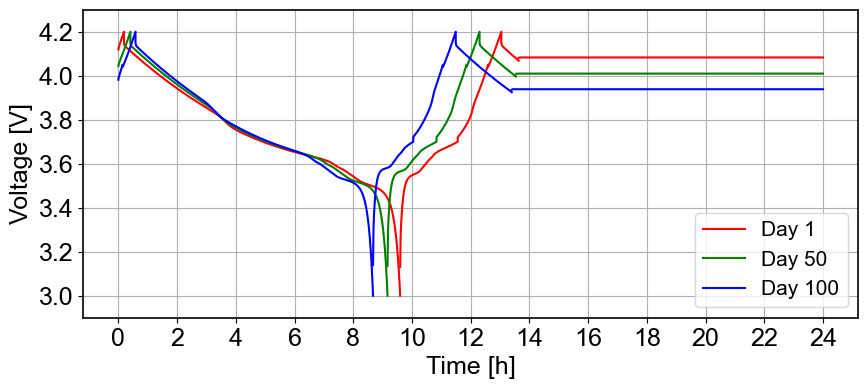

In [5]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18
plt.figure(1,figsize=(10,4))
plt.grid()
i = 1
time_h_1 = solution.cycles[i*3]['Time [h]'].entries
time_h_2 = solution.cycles[i*3+1]['Time [h]'].entries
time_h_3 = solution.cycles[i*3+2]['Time [h]'].entries
plt.plot((time_h_1-time_h_1[0]), solution.cycles[i*3]['Voltage [V]'].entries,c='r',label='Day 1')
plt.plot((time_h_2-time_h_1[0]), solution.cycles[i*3+1]['Voltage [V]'].entries,c='r')
plt.plot((time_h_3-time_h_1[0]), solution.cycles[i*3+2]['Voltage [V]'].entries,c='r')

i = 49
time_h_1 = solution.cycles[i*3]['Time [h]'].entries
time_h_2 = solution.cycles[i*3+1]['Time [h]'].entries
time_h_3 = solution.cycles[i*3+2]['Time [h]'].entries
plt.plot((time_h_1-time_h_1[0]), solution.cycles[i*3]['Voltage [V]'].entries,c='g',label='Day 50')
plt.plot((time_h_2-time_h_1[0]), solution.cycles[i*3+1]['Voltage [V]'].entries,c='g')
plt.plot((time_h_3-time_h_1[0]), solution.cycles[i*3+2]['Voltage [V]'].entries,c='g')

i = 99
time_h_1 = solution.cycles[i*3]['Time [h]'].entries
time_h_2 = solution.cycles[i*3+1]['Time [h]'].entries
time_h_3 = solution.cycles[i*3+2]['Time [h]'].entries
plt.plot((time_h_1-time_h_1[0]), solution.cycles[i*3]['Voltage [V]'].entries,c='b',label='Day 100')
plt.plot((time_h_2-time_h_1[0]), solution.cycles[i*3+1]['Voltage [V]'].entries,c='b')
plt.plot((time_h_3-time_h_1[0]), solution.cycles[i*3+2]['Voltage [V]'].entries,c='b')
plt.ylim(2.9,4.3)
plt.xticks([0,2,4,6,8,10,12,14,16,18,20,22,24])
plt.yticks([3.0,3.2,3.4,3.6,3.8,4.0,4.2])
plt.xlabel('Time [h]')
plt.ylabel('Voltage [V]')
plt.legend(loc='lower right',fontsize=15)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.2)
plt.show()

In [6]:
Q_loss_arr = capa_0 - solution.summary_variables['Capacity [A.h]']
Q_loss_arr = np.insert(Q_loss_arr, 0, 0)

# Capacity retention
cap_ret = (capa_0-Q_loss_arr)/capa_0

start_idx = n_exp_per_day_arr[0]
ch_time = solution.cycles[start_idx].steps[-1]['Time [h]'].entries[0]-solution.cycles[start_idx]['Time [h]'].entries[0]
# print(ch_time)
for s in range(n_exp_per_day_arr[1]-2):
    ch_time+=solution.cycles[start_idx+1].steps[-1]['Time [h]'].entries[0]-solution.cycles[start_idx+1]['Time [h]'].entries[0]
#     print(solution.cycles[start_idx+1].steps[-1]['Time [h]'].entries[0]-solution.cycles[start_idx+1]['Time [h]'].entries[0])

print('Charging time [min]: ',np.round(ch_time*60,2))
print('Capacity retention [%]: ', np.round(cap_ret[-1]*100,2))

Charging time [min]:  218.15
Capacity retention [%]:  86.17
